# Tutorial 2.4: Three-Body Potential Energy Surface

Next, we will parameterize the "physical baseline" ($V_{phys}$) of the PEF.

In this section, we construct, from scratch, a 1-body MB-nrg-style PEF for CH3-NH2.

## 2.1.0 Definitions and Imports

In [59]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
%run Tutorial_2_Imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
%run Tutorial_2_Paths.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's generate the second set of configurations for our training set, those from metadynamics configurations.

## II.1.? Normal Modes Configuration Generation

In [63]:
definition_CH3NH2 = read_definition(paths.definitions.systems.CH3NH2)
minimized_structure_CH3NH2, minimized_energy_CH3NH2 = read_system_and_energy(definition_CH3NH2, paths.structures.minimized_CH3NH2)

definition_H2O = read_definition(paths.definitions.systems.H2O)
minimized_structure_H2O, minimized_energy_H2O = read_system_and_energy(definition_H2O, paths.structures.minimized_H2O)

definition_CH3NH2_H2O_H2O = read_definition(paths.definitions.systems.CH3NH2_H2O_H2O)

In [64]:
clusters_CH3NH2_H2O_H2O = read_systems(definition_CH3NH2_H2O_H2O, paths.clusters.CH3NH2_H2O_H2O)
vibrational_modes_clusters_CH3NH2_H2O_H2O = read_multiple_vibrational_modes(paths.clusters.CH3NH2_H2O_H2O_modes)

In [65]:
configurations_vibrational_modes_CH3NH2_H2O_H2O = []

for cluster, modes in zip(clusters_CH3NH2_H2O_H2O, vibrational_modes_clusters_CH3NH2_H2O_H2O):
    configuration_generator = NormalModesConfigurationGenerator(
            cluster,
            modes,
            distribution="linear",
            temperature=(10, 150)
    )

    configs = list(configuration_generator.generate_configurations(num_configs=300, seed=54321))
    configurations_vibrational_modes_CH3NH2_H2O_H2O.extend(configs)
    
write_systems(paths.PIP_CH3NH2_H2O_H2O.configs.vibrational_modes, configurations_vibrational_modes_CH3NH2_H2O_H2O)

Will generate configurations over a linear temperature distribution from 10 K to 150 K.
Temp Distribution: temp (au) = 0.0004433562 * x + 3.1668299999999996e-05 for x in range [0,1].
Beginning normal modes configuration generation.
Will generate 300 configs over the temperature distribution.
Generating Temperature Distribution Configs...
Normal Distribution Configuration generation complete! Generated 300 configs.
Will generate configurations over a linear temperature distribution from 10 K to 150 K.
Temp Distribution: temp (au) = 0.0004433562 * x + 3.1668299999999996e-05 for x in range [0,1].
Beginning normal modes configuration generation.
Will generate 300 configs over the temperature distribution.
Generating Temperature Distribution Configs...
Normal Distribution Configuration generation complete! Generated 300 configs.
Will generate configurations over a linear temperature distribution from 10 K to 150 K.
Temp Distribution: temp (au) = 0.0004433562 * x + 3.1668299999999996e-05 for

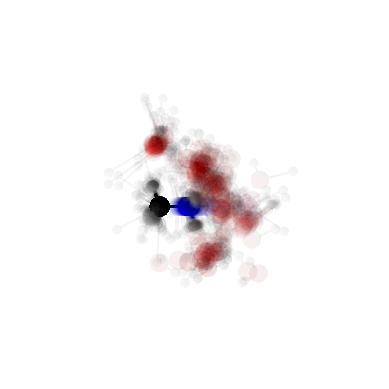

In [66]:
render_overlayed_systems(
    configurations_vibrational_modes_CH3NH2_H2O_H2O,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[4].point, system.atoms[3].point),
    alpha=0.03,
    num_to_show=100
)

Let's generate the second set of configurations for our training set, those from metadynamics configurations.

## II.1.? Parallel-Bias Metadynamics Configuration Generation

In [34]:
vibrational_modes_CH3NH2_H2O_H2O = read_multiple_vibrational_modes(paths.clusters.CH3NH2_H2O_H2O_modes)[0]

In [35]:
bond_params, angle_params, nonbonded_params = get_pbmetad_parameters(
        clusters_CH3NH2_H2O_H2O[0]
)

In [36]:
bond_params

{('A', 'B'): (60, 1.090410024347401),
 ('A', 'C'): (100, 1.4843142427207179),
 ('C', 'D'): (60, 1.0355461195163942),
 ('E', 'F'): (60, 0.9895526574811143)}

In [37]:
angle_params

{('B', 'A', 'C'): (15, 110.73761574767536),
 ('B', 'A', 'B'): (15, 108.16415660139323),
 ('F', 'E', 'F'): (15, 101.40817132883848),
 ('A', 'C', 'D'): (15, 108.21981201112177),
 ('D', 'C', 'D'): (15, 105.76182010902501)}

In [38]:
nonbonded_params

{'A': (0.03, 1.8),
 'B': (0.01, 0.9),
 'C': (0.03, 1.8),
 'D': (0.01, 0.9),
 'E': (0.03, 1.8),
 'F': (0.01, 0.9)}

In [39]:
charges = read_parameters(paths.Vphys.charges)
charges = {symmetry: charges[symmetry]*1/3 for symmetry in charges}
charges["E"] = -0.6*1/3
charges["F"] = +0.3*1/3

In [ ]:
# paths.scratch.pbmetad_CH3NH2_H2O_H2O.remove()
# paths.restart.pbmetad_CH3NH2_H2O_H2O.remove()

In [41]:
perform_pbmetad_simulation(
        lammps_executable_path,
        [minimized_structure_CH3NH2, minimized_structure_H2O, minimized_structure_H2O],
        num_configs=500000,
        sample_interval=10,
        temperature=700,
        seed=12345,
        configurations_path=paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_pool,
        bond_params=bond_params,
        angle_params=angle_params,
        nonbonded_params=nonbonded_params,
        charges=charges,
        pbmetad_workdir=paths.scratch.pbmetad_CH3NH2_H2O_H2O,
        restart_path=paths.restart.pbmetad_CH3NH2_H2O_H2O,
        min_intermolecular_distance=1.5,
        max_intermolecular_distance=6
)

Preparing PBMetaD Simulation...
Running PBMetaD Simulation...
Converting PBMetaD trajectory to XYZ...


In [42]:
inner_cutoff_3b = 4.5
outer_cutoff_3b = 5.5

In [49]:
num_filtered_configs = filter_configs_by_cutoff(
        definition_CH3NH2_H2O_H2O,
        paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_pool,
        threshold=outer_cutoff_3b,
        filtered_path=paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_pool_filtered
)

Found 222055 within cutoff distance of 5.5


In [50]:
split_pool(
        definition_CH3NH2_H2O_H2O,
        paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_pool_filtered,
        pool_size=num_filtered_configs,
        num_configs_to_split=200,
        unsplit_path=paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_train_pool,
        split_path=paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_test,
        strategy="INTERVAL",
)

In [51]:
# paths.scratch.fps_CH3NH2_H2O_H2O.remove()
# paths.restart.fps_CH3NH2_H2O_H2O.remove()

In [52]:
pbmetad_configs_CH3NH2_H2O_H2O = perform_fps(
        definition_CH3NH2_H2O_H2O,
        clusters_CH3NH2_H2O_H2O[0],
        vibrational_modes_clusters_CH3NH2_H2O_H2O[0],
        paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_train_pool,
        num_pool_configs=num_filtered_configs-200,
        num_phase1_input_configs=100000,
        approx_configs_to_select=1000,
        fps_workdir=paths.scratch.fps_CH3NH2_H2O_H2O,
        restart_path=paths.restart.fps_CH3NH2_H2O_H2O,
        num_threads=16
)

Number of permutations: 96
Beginning featurization...
Featurization progress: |====================================================================================================| - 100000/100000
Featurized 100000 configurations.
Initializing round 1 FPS...
BallTree built!
Performing round 1 FPS...
Round 1 FPS iterations: |====================================================================================================| - 1000/1000
Completed round 1 fps, selected 1000 configs, max distance: 3.677626510477045
Number of permutations: 96
Beginning featurization...
Featurization progress: |====================================================================================================| - 121855/121855
Featurized 121855 configurations.
Initializing round 2 FPS...
BallTree built!
Performing round 2 FPS...
Round 2 FPS iterations: 131
Completed round 2 fps, selected 131 configs.
Selected 1131 total configs by FPS.


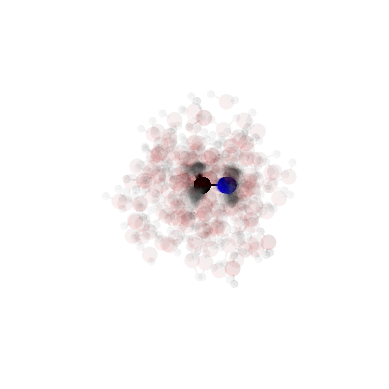

In [57]:
render_overlayed_systems(
    pbmetad_configs_CH3NH2_H2O_H2O,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[4].point, system.atoms[3].point),
    alpha=0.03,
    num_to_show=100
)

In [58]:
write_systems(paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_train, pbmetad_configs_CH3NH2_H2O_H2O)

## II.1.? Energy Calculation

Next, we need to perform the electronic structure calculations with our chosen reference level of theory. We will use CCSD(T). Because this can be quite expensive and this tutorial is menat to be something that can be finished in a few hours, we have precomputed the energies for you. So we will just copy them over:

In [67]:
calculator = Psi4Calculator("HF", "STO-3G", paths.logs)

In [ ]:
energies_vibrational_modes_CH3NH2_H2O_H2O = calculate_nmer_energies(
        configurations_vibrational_modes_CH3NH2_H2O_H2O,
        calculator,
        get_qchem_job_manager(paths.jobs),
        paths.restart.energies_vibrational_mode_configs_CH3NH2_H2O_H2O,
        num_threads=4,
        mem_mb=8000
)
write_systems_and_nmer_energies(paths.PIP_CH3NH2_H2O_H2O.configs.vibrational_modes_energies, (configurations_vibrational_modes_CH3NH2_H2O_H2O, energies_vibrational_modes_CH3NH2_H2O_H2O))

In [ ]:
energies_pbmetad_CH3NH2_H2O_H2O = calculate_nmer_energies(
        pbmetad_configs_CH3NH2_H2O_H2O,
        calculator,
        get_qchem_job_manager(paths.jobs),
        paths.restart.energies_pbmetad_configs_CH3NH2_H2O_H2O,
        num_threads=4,
        mem_mb=8000
)
write_systems_and_nmer_energies(paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_train_energies, (pbmetad_configs_CH3NH2_H2O_H2O, energies_pbmetad_CH3NH2_H2O_H2O))

In [41]:
energies_2b_vibrational_modes_CH3NH2_H2O_H2O = calculate_many_body_energies(
    configurations_vibrational_modes_CH3NH2_H2O_H2O,
    energies_vibrational_modes_CH3NH2_H2O_H2O,
    minimized_monomer_energies=[minimized_energy_CH3NH2, minimized_energy_H2O, minimized_energy_H2O]
)

energies_2b_pbmetad_CH3NH2_H2O_H2O = calculate_many_body_energies(
    pbmetad_configs_CH3NH2_H2O_H2O,
    energies_pbmetad_CH3NH2_H2O_H2O,
    minimized_monomer_energies=[minimized_energy_CH3NH2, minimized_energy_H2O, minimized_energy_H2O]
)

In [42]:
write_training_set_file(
        paths.PIP_CH3NH2_H2O_H2O.training_set,
        (
                [*configurations_vibrational_modes_CH3NH2_H2O_H2O, *pbmetad_configs_CH3NH2_H2O_H2O],
                [*energies_1b_vibrational_modes_CH3NH2_H2O_H2O, *energies_1b_pbmetad_CH3NH2_H2O_H2O],
                [*energies_1b_vibrational_modes_CH3NH2_H2O_H2O, *energies_1b_pbmetad_CH3NH2_H2O_H2O],
        )
)

In [43]:
min(energies_1b_vibrational_modes_CH3NH2_H2O_H2O), max(energies_1b_vibrational_modes_CH3NH2_H2O_H2O)

(0.07426190999831306, 148.74226191000344)

In [44]:
min(energies_1b_pbmetad_CH3NH2_H2O_H2O), max(energies_1b_pbmetad_CH3NH2_H2O_H2O)

(46.52726190999965, 537.3892619100006)